In [1]:
import os
import cv2
from matplotlib import pyplot as plt

# Shifting the image by a margin of pixels
import skimage.transform as trans
from scipy import signal
from PIL import Image
from scipy import stats as stat
from itertools import product

# Image Analysis
import numpy as np
from scipy.fft import fft, ifft

import glob
import os

from tifffile import imread
from matplotlib import pyplot as plt
from skimage import io, exposure, data
import numpy as np
from PIL import Image
from scipy import stats as st

from scipy.optimize import minimize
from numpy import diff
from scipy.signal import find_peaks

from skimage import exposure
from skimage.filters import unsharp_mask
# from wand.image import Image as ImageWand
from numpy.polynomial import polynomial as P

In [12]:
import numpy as np
import cv2

def save_video(filename, frames):
    # frames_rgb: (N, H, W, 3) uint8 in RGB
    h, w = frames.shape[1], frames.shape[2]
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(filename, fourcc, 15.0, (w, h), isColor=True)

    for fr in frames:
        fr_bgr = cv2.cvtColor(fr, cv2.COLOR_GRAY2BGR)
        out.write(fr_bgr)

    out.release()
    print(f"Saved {filename}")

In [2]:
import cv2
from PIL import Image

# Dirty Implementation of Shifting Images
def ShiftedImage_2D(Image, XShift, YShift):
    # Quick guard
    if (XShift == 0 and YShift == 0):
        return Image

    M = np.float32([
        [1, 0, XShift],
        [0, 1, YShift]
    ])

    shifted = cv2.warpAffine(Image, M, (Image.shape[1], Image.shape[0]))
    shifted_image = shifted

    # Shift Down
    if (YShift > 0):
        shifted_image = shifted_image[YShift:]
        shifted_image = np.pad(shifted_image, ((YShift, 0), (0, 0)), 'edge')  # Pad Up

    # Shift Up
    if (YShift < 0):
        shifted_image = shifted_image[:shifted.shape[0] - abs(YShift)]
        shifted_image = np.pad(shifted_image, ((0, abs(YShift)), (0, 0)), 'edge')  # Pad Down

    # Shift Left
    if (XShift > 0):
        shifted_image = np.delete(shifted_image, slice(0, XShift), 1)
        shifted_image = np.pad(shifted_image, ((0, 0), (XShift, 0)), 'edge')  # Pad Left

    if (XShift < 0):
        shifted_image = np.delete(shifted_image, slice(shifted.shape[1] - abs(XShift), shifted.shape[1]), 1);
        shifted_image = np.pad(shifted_image, ((0, 0), (0, abs(XShift))), 'edge');  # Pad Right

    return shifted_image

# sum of absolute differences (SAD) metric alignment, quick n dirty
def SAD(A, B):
    cutA = A.ravel();
    cutB = B.ravel();
    MAE = np.sum(np.abs(np.subtract(cutA, cutB, dtype=np.float64))) / cutA.shape[0]
    return MAE

# We use a Tree Search Algorithm to find possible alignment
# Let Image_1 be the orginal
# Let Image_2 be the aligned
# Displacement object is our nodes, [x,y]
# Assumption, there is always a better alignment up, down, left, and right if its not the same image
def alignment_MAE(Image_1, Image_2, depth_cap):
    iterative_cap = 0
    Best_SAD = SAD(Image_1, Image_2)
    Best_Displacement = [0, 0]
    q = []
    visited_states = [[0, 0]]  # Add (0,0) displacement
    q.append(Best_Displacement)  # Append (0,0) displacement

    while (iterative_cap != depth_cap and q):
        curr_state = q.pop(0);
        x = curr_state[0];
        y = curr_state[1];

        iterative_cap += 1;

        movement_arr = [
            [x, y - 1],  # Up
            [x, y + 1],  # Down
            [x + 1, y],  # Left
            [x - 1, y],  # Right
            [x - 1, y - 1],  # Diagonal
            [x + 1, y + 1],  # Diagonal
            [x + 1, y - 1],  # Diagonal
            [x - 1, y + 1],  # Diagonal
        ]

        for move in movement_arr:
            if (move not in visited_states):
                visited_states.append(move)  # Marked as Visited

                # Perform shift and calculate
                new_image = ShiftedImage_2D(Image_2, move[0], move[1])
                cand_SAD = SAD(Image_1, new_image)

                if (cand_SAD < Best_SAD):
                    Best_SAD = cand_SAD
                    Best_Displacement = move

                    q.append(move)

                # This means we cannot find a better move.

    return Best_Displacement, Best_SAD

# Vec4f is (x1, y1, x2, y2)
def y_shift_emphasis(image, block_threshold, MAE_shift, plot_debug=False):
    output_img = image

    # Need to turn into uint8 for Straight Line Detection
    img = np.uint8(image)
    lsd = cv2.createLineSegmentDetector(0)
    lines_contour = lsd.detect(img)[0]

    if plot_debug:
        drawn_img = lsd.drawSegments(img, lines_contour);
        plt.imshow(drawn_img, cmap='gray')
        plt.title('Drawn Image')
        plt.show()

    horizontal_lines = {};
    for x in lines_contour:
        for y in x:
            cand_gradient = abs(y[1] - y[3])
            if (cand_gradient < 10):
                horizontal_lines[cand_gradient] = y

    horz = list(horizontal_lines.values())

    top_y = np.min(horz);
    bottom_y = np.max(horz);

    return top_y, bottom_y

def remove_stage_jitter_MAE(input_images, iteration_depth, plot_debug=False):
    # Add Scores path just for curiosity
    scores = []
    result = []

    # # Create Output folder
    # if (not os.path.exists(output_path)):
    #     os.makedirs(output_path);

    # # Get training image files list:
    # image_name_arr = glob.glob(os.path.join(source_path, "*.png")) + glob.glob(os.path.join(source_path, "*.tif"));
    # image_name_arr_sorted = sorted(image_name_arr, key = lambda x:x[48:57]);

    # base_image = os.path.basename(image_name_arr_sorted[0]);
    # base = cv2.imread(os.path.join(source_path, base_image), cv2.IMREAD_ANYDEPTH)

    base = input_images[0]

    if base.ndim == 3:
        base = base[:, :, 0]  # Reduce to the 2D

    base_top, base_bottom = y_shift_emphasis(base, 15, 0)
    iteration = 0

    for img in input_images[1:]:
        iteration += 1
        template_image = img

        if template_image.ndim == 3:
            template_image = template_image[:, :, 0]  # Reduce to the 2D

        template_top, template_bottom = y_shift_emphasis(template_image, 15, 0)

        displacement, score = alignment_MAE(base, template_image, iteration_depth)
        scores.append(score)
        shifted_image = ShiftedImage_2D(template_image, displacement[0], int(np.mean(
            [(base_top - template_top), (base_bottom - template_bottom)])))  # X,Y

        # For my purposes
        background = Image.fromarray(np.uint8(base))
        overlay = Image.fromarray(np.uint8(shifted_image))
        new_img = Image.blend(background, overlay, 0.5)

        if plot_debug:
            print("Overlay to show frame jitter")
            print("Overlay for image", iteration)
            plt.imshow(new_img, cmap='gray')
            plt.title('New Image')
            # plt.imshow(shifted_image, cmap='gray')
            plt.show()

        # Write the new image in target folder
        shifted_image = exposure.rescale_intensity(shifted_image)  # Get rid of low exposure
        result.append(shifted_image)

    print("Scores:", scores)

    return result, scores

In [3]:
import matplotlib.pyplot as plt
# Load images
import nd2

test_dataset = nd2.imread(
    '/Users/hiram/Documents/EVERYTHING/20-29 Research/22 OliveiraLab/22.12 ND2 analyzer/nd2-analyzer/SR_1_5_2h_Pre-C_3h_IPTG_After10h_05_MC.nd2',
    dask=True)
test_pos_over_time = test_dataset[:, 0, 0].compute()

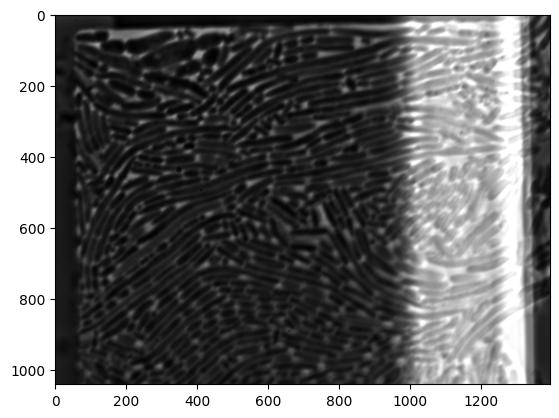

In [4]:
plt.imshow(test_pos_over_time[0], cmap='gray')

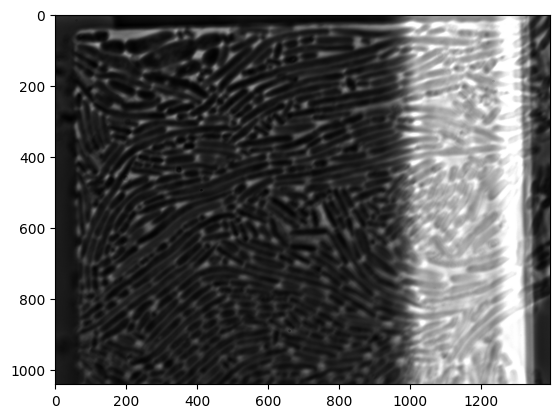

putaaa
Scores: [10.45304003647215, 13.268924071618038, 14.849982730990273, 15.466349607648098, 16.05486709770115, 16.657329658488063, 17.33259698275862, 17.834448911361626, 17.73529094827586, 16.963797938771, 17.55768885389036, 18.090424679487178, 18.174955100574714, 18.559013041556145, 18.696605603448276, 18.738236350574713, 19.05905863174182, 19.038758565428825, 19.94563577586207, 19.795035505083998, 19.655760941644562, 19.561981238947833, 19.16479263373121, 19.18216732979664, 19.215225740495136, 19.23848087975243, 19.292997761936338, 19.322980907382846, 19.236966042219276, 19.089096347259062, 19.15999323054819, 18.85078194076039, 18.752137903404066, 18.452448054818746, 18.891767517683466, 19.095738699160034]


In [5]:
# Normalization
norm = cv2.normalize(test_pos_over_time, None, 0, 65535, cv2.NORM_MINMAX)
plt.imshow(norm[0], cmap='gray')
plt.show()
print('putaaa')
# frames: (N,H,W) uint8
frames = ((norm / 65535) * 255).astype(np.uint8)
frames_rgb = np.stack([frames] * 3, axis=-1)  # (N,H,W,3)
aligned, scores = remove_stage_jitter_MAE(frames, 1000)

In [15]:
# Save both timelapses and evaluate
save_video("original.mp4", frames)
save_video("registered.mp4", np.array(aligned))

Saved original.mp4
Saved registered.mp4


## Register with skimage (not good)

In [11]:
from skimage.registration import phase_cross_correlation


def register_timestack(images):
    registered = [images[0]]  # First frame as reference
    shifts = [(0, 0)]

    for i in range(1, len(images)):
        shift, error, phase_diff = phase_cross_correlation(
            images[0], images[i],
            upsample_factor=100  # for sub-pixel precision
        )
        registered.append(np.roll(images[i], shift.astype(int), axis=(0, 1)))
        shifts.append(shift)

    return registered, shifts

In [3]:
import matplotlib.pyplot as plt


# frames: a NumPy array of shape (N, H, W) or (N, H, W, 3)
def show_frames_matplotlib(frames, delay=0.1):
    plt.ion()  # interactive mode on
    fig, ax = plt.subplots()
    for frame in frames:
        ax.clear()
        if frame.ndim == 2:
            ax.imshow(frame, cmap='gray', vmin=0, vmax=255)
        else:
            ax.imshow(frame)
        ax.axis('off')
        display(fig)
        plt.pause(delay)
    plt.ioff()
    plt.show()

In [30]:

import numpy as np
import cv2

# Normalization
norm = cv2.normalize(test_pos_over_time.compute(), None, 0, 65535, cv2.NORM_MINMAX)
# plt.imshow(norm[0], cmap='gray')
# frames: (N,H,W) uint8
frames = ((norm / 65535) * 255).astype(np.uint8)
frames_rgb = np.stack([frames] * 3, axis=-1)  # (N,H,W,3)

# frames_rgb: (N, H, W, 3) uint8 in RGB
h, w = frames_rgb.shape[1], frames_rgb.shape[2]
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("timelapse.mp4", fourcc, 15.0, (w, h), isColor=True)

for fr in frames_rgb:
    fr_bgr = cv2.cvtColor(fr, cv2.COLOR_RGB2BGR)
    out.write(fr_bgr)

out.release()
print("Saved timelapse.mp4")


Saved timelapse.mp4


In [31]:
frames_rgb.shape

(37, 1040, 1392, 3)

In [32]:
# Do the registration
registered, shifts = register_timestack(frames)

In [33]:

import numpy as np
import cv2

# # frames: (N,H,W) uint8
# frames = ((test_pos_over_time / 65535) * 255).compute().astype(np.uint8)
# frames_rgb = np.stack([frames]*3, axis=-1)  # (N,H,W,3)

# frames_rgb: (N, H, W, 3) uint8 in RGB
h, w = frames.shape[1], frames.shape[2]
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("registered.mp4", fourcc, 15.0, (w, h), isColor=True)

for fr in registered:
    fr_bgr = cv2.cvtColor(fr, cv2.COLOR_GRAY2BGR)
    out.write(fr_bgr)

out.release()
print("Saved timelapse.mp4")


Saved timelapse.mp4
